In [1]:
# Protein Fitness Prediction Utilities
# This notebook demonstrates utility functions for sequence processing and metrics

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

import numpy as np
from scipy.stats import spearmanr
from Bio import SeqIO
from sklearn.metrics import roc_auc_score, ndcg_score

In [2]:
aa_to_int = {'M': 1, 'R': 2, 'H': 3, 'K': 4, 'D': 5, 'E': 6, 'S': 7, 'T': 8, 'N': 9, 'Q': 10, 'C': 11, 'U': 12, 'G': 13,
             'P': 14, 'A': 15, 'V': 16, 'I': 17, 'F': 18, 'Y': 19, 'W': 20, 'L': 21, 'O': 22,  # Pyrrolysine
             'X': 23,  # Unknown
             'Z': 23,  # Glutamic acid or GLutamine
             'B': 23,  # Asparagine or aspartic acid
             'J': 23,  # Leucine or isoleucine
             'start': 24, 'stop': 25, '-': 26}
int_to_aa = {value: key for key, value in aa_to_int.items()}

In [3]:
def is_valid_seq(seq, max_len=2000):
    """
    True if seq is valid for the babbler, False otherwise.
    """
    l = len(seq)
    valid_aas = "MRHKDESTNQCUGPAVIFYWLO"
    if (l < max_len) and set(seq) <= set(valid_aas):
        return True
    else:
        return False

In [4]:
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

In [5]:
def spearman(y_pred, y_true):
    if np.var(y_pred) < 1e-6 or np.var(y_true) < 1e-6:
        return 0.0
    return spearmanr(y_pred, y_true).correlation

In [6]:
def ndcg(y_pred, y_true):
    y_true_normalized = (y_true - y_true.mean()) / y_true.std()
    return ndcg_score(y_true_normalized.reshape(1, -1), y_pred.reshape(1, -1))

In [7]:
def auroc(y_pred, y_true, y_cutoff=1.0):
    y_true_bin = (y_true >= y_cutoff)
    return roc_auc_score(y_true_bin, y_pred, average='micro')

In [8]:
def format_seq(seq, stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq

In [9]:
def format_batch_seqs(seqs):
    maxlen = -1
    for s in seqs:
        if len(s) > maxlen:
            maxlen = len(s)
    formatted = []
    for seq in seqs:
        pad_len = maxlen - len(seq)
        padded = np.pad(format_seq(seq), (0, pad_len), 'constant', constant_values=0)
        formatted.append(padded)
    return np.stack(formatted)

In [10]:
def seqs_to_onehot(seqs):
    seqs = format_batch_seqs(seqs)
    X = np.zeros((seqs.shape[0], seqs.shape[1]*24), dtype=int)
    for i in range(seqs.shape[1]):
        for j in range(24):
            X[:, i*24+j] = (seqs[:, i] == j)
    return X

In [11]:
def get_wt_seq(mutation_descriptions):
    wt_len = 0
    for m in mutation_descriptions:
        if m == 'WT':
            continue
        if int(m[1:-1]) > wt_len:
            wt_len = int(m[1:-1])
    wt = ['?' for _ in range(wt_len)]
    for m in mutation_descriptions:
        if m == 'WT':
            continue
        idx, wt_char = int(m[1:-1])-1, m[0]   # 1-index to 0-index
        if wt[idx] == '?':
            wt[idx] = wt_char
        else:
            assert wt[idx] == wt_char
    return ''.join(wt), wt_len

In [12]:
def seq2mutation(seq, model, return_str=False, ignore_gaps=False,
        sep=":", offset=1):
    mutations = []
    for pf, pm in model.index_map.items():
        if seq[pf-offset] != model.target_seq[pm]:
            if ignore_gaps and (
                    seq[pf-offset] == '-' or seq[pf-offset] not in model.alphabet):
                continue
            mutations.append((pf, model.target_seq[pm], seq[pf-offset]))
    if return_str:
        return sep.join([m[1] + str(m[0]) + m[2] for m in mutations])
    return mutations

In [13]:
def seq2effect(seqs, model, offset=1, ignore_gaps=False):
    effects = np.zeros(len(seqs))
    for i in range(len(seqs)):
        mutations = seq2mutation(seqs[i], model, ignore_gaps=ignore_gaps, offset=offset)
        dE, _, _ = model.delta_hamiltonian(mutations)
        effects[i] = dE
    return effects

In [14]:
def mutant2seq(mut, wt, offset):
    if mut.upper() == 'WT':
        return wt
    chars = list(wt)
    mut = mut.replace(':', ',')
    mut = mut.replace(';', ',')
    for m in mut.split(','):
        idx = int(m[1:-1])-offset
        assert wt[idx] == m[0]
        chars[idx] = m[-1]
    return ''.join(chars)

## Demonstration: Testing Utility Functions

Below we demonstrate key utility functions with example protein sequences and metrics.

In [15]:
# Test 1: Sequence Validation
test_sequences = [
    "MRHKDESTNQ",  # Valid sequence
    "MRHKDESTNQXYZ",  # Contains invalid character Z
    "MRHK" * 600,  # Too long (>2000)
]

print("Sequence Validation Tests:")
for i, seq in enumerate(test_sequences):
    print(f"Sequence {i+1} (length={len(seq)}): {is_valid_seq(seq)}")

Sequence Validation Tests:
Sequence 1 (length=10): True
Sequence 2 (length=13): False
Sequence 3 (length=2400): False


In [16]:
# Test 2: Amino Acid to Integer Encoding
test_seq = "MRHKD"
int_encoding = aa_seq_to_int(test_seq)
print(f"\nAmino Acid Encoding:")
print(f"Sequence: {test_seq}")
print(f"Integer encoding: {int_encoding}")
print(f"(24=start, 25=stop)")

# Test format_seq
formatted = format_seq(test_seq, stop=False)
print(f"\nFormatted sequence (no stop): {formatted}")


Amino Acid Encoding:
Sequence: MRHKD
Integer encoding: [24, 1, 2, 3, 4, 5, 25]
(24=start, 25=stop)

Formatted sequence (no stop): [24, 1, 2, 3, 4, 5]


In [17]:
# Test 3: One-Hot Encoding
test_seqs = ["MRHK", "DESTNQ", "CA"]
onehot = seqs_to_onehot(test_seqs)
print(f"\nOne-Hot Encoding:")
print(f"Input sequences: {test_seqs}")
print(f"One-hot matrix shape: {onehot.shape}")
print(f"(rows=sequences, cols=positions*24_amino_acids)")
print(f"\nFirst row (partial): {onehot[0, :48]}")  # Show first 2 positions


One-Hot Encoding:
Input sequences: ['MRHK', 'DESTNQ', 'CA']
One-hot matrix shape: (3, 168)
(rows=sequences, cols=positions*24_amino_acids)

First row (partial): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
# Test 4: Evaluation Metrics
np.random.seed(42)
y_true = np.random.randn(100)
y_pred = y_true + 0.3 * np.random.randn(100)  # Correlated predictions

print(f"\nEvaluation Metrics:")
print(f"Spearman correlation: {spearman(y_pred, y_true):.4f}")

# NDCG requires non-negative values - call ndcg_score directly
y_true_pos = y_true - y_true.min() + 1.0  # Make all values positive
y_pred_pos = y_pred - y_pred.min() + 1.0
ndcg_value = ndcg_score(y_true_pos.reshape(1, -1), y_pred_pos.reshape(1, -1))
print(f"NDCG score (direct call): {ndcg_value:.4f}")

# AUROC requires binary labels
y_true_fitness = np.random.randn(100)
y_pred_fitness = y_true_fitness + 0.5 * np.random.randn(100)
try:
    auroc_score = auroc(y_pred_fitness, y_true_fitness, y_cutoff=0.0)
    print(f"AUROC (cutoff=0.0): {auroc_score:.4f}")
except Exception as e:
    print(f"AUROC calculation error: {e}")


Evaluation Metrics:
Spearman correlation: 0.9486
NDCG score (direct call): 0.9963
AUROC (cutoff=0.0): 0.9713


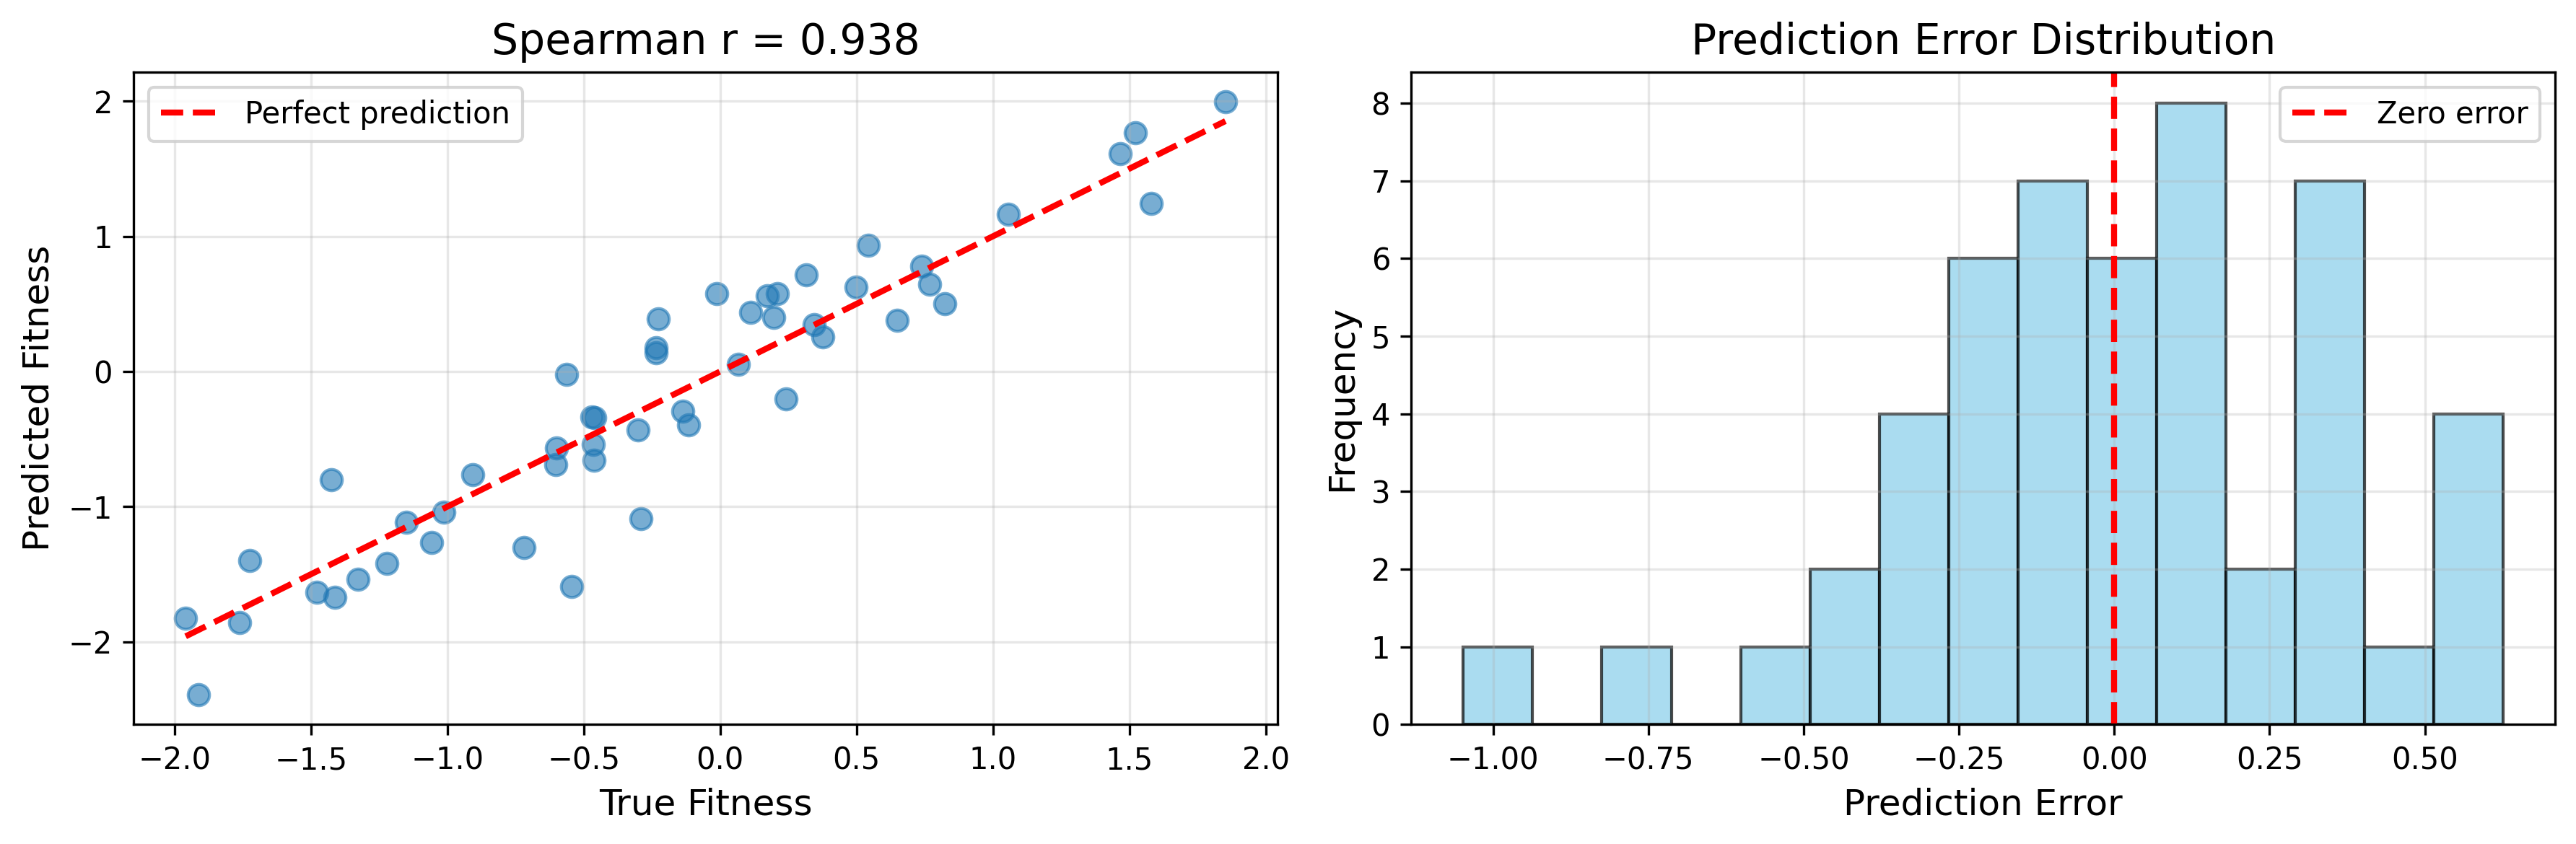


Metrics Visualization saved to notebooks/util/metrics_visualization.png


In [19]:
# Test 5: Visualize Metrics Performance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Correlation visualization
np.random.seed(42)
y_true_vis = np.random.randn(50)
y_pred_vis = y_true_vis + 0.4 * np.random.randn(50)

axes[0].scatter(y_true_vis, y_pred_vis, alpha=0.6, s=50)
axes[0].plot([y_true_vis.min(), y_true_vis.max()], 
             [y_true_vis.min(), y_true_vis.max()], 
             'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('True Fitness', fontsize=12)
axes[0].set_ylabel('Predicted Fitness', fontsize=12)
axes[0].set_title(f'Spearman r = {spearman(y_pred_vis, y_true_vis):.3f}', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Prediction error distribution
errors = y_pred_vis - y_true_vis
axes[1].hist(errors, bins=15, edgecolor='black', alpha=0.7, color='skyblue')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Prediction Error', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Prediction Error Distribution', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('notebooks/util/metrics_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMetrics Visualization saved to notebooks/util/metrics_visualization.png")